In [1]:
import numpy as np

In [2]:
M = 20  # kg
g = 9.8 # m / s^2
m = 0.5 # kg
l = 0.5 # m

In [3]:
v1 = ((M + m) * g) / (M * l)
v2 = -(m * g) / M

c1 = -1 / (M * l)
c2 = 1 / M

In [4]:
A = np.array([[0, 1, 0, 0], [0, 0, v2, 0], [0, 0, 0, 1], [0, 0, v1, 0]])
B = np.array([[0], [c2], [0], [c1]])

In [5]:
print(np.shape(A))
print(np.shape(B))

(4, 4)
(4, 1)


## Controllability

CM = [B AB A<sup>2</sup>B A<sup>3</sup>B]

In [6]:
CM = np.array([[B], [A @ B], [A @ A @ B], [A @ A @ A @ B]]).reshape(4, 4)

In [7]:
print((CM))

[[ 0.      0.05    0.     -0.1   ]
 [ 0.05    0.     -0.1     0.    ]
 [ 0.      0.0245  0.     -2.009 ]
 [ 0.0245  0.     -2.009   0.    ]]


In [8]:
rank = np.linalg.matrix_rank(CM)
print("Rank of CM: ", rank)

Rank of CM:  4


> Rank of CM = 4, therefore controllable

## Stability


In [9]:
print(A)

[[ 0.     1.     0.     0.   ]
 [ 0.     0.    -0.245  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.    20.09   0.   ]]


In [10]:
eigenvalues = np.linalg.eigvals(A)

print("Eigenvalues of matrix A:", eigenvalues)

Eigenvalues of matrix A: [ 0.          0.          4.48218697 -4.48218697]


>One eigen value is positive, so the system is unstable

## Policy Iteration


In [11]:
Q = np.diag([100, 100, 1, 1])
R = np.array([[0.1]])


In [12]:
print("A:\n", A)
print("B:\n", B)

A:
 [[ 0.     1.     0.     0.   ]
 [ 0.     0.    -0.245  0.   ]
 [ 0.     0.     0.     1.   ]
 [ 0.     0.    20.09   0.   ]]
B:
 [[ 0.  ]
 [ 0.05]
 [ 0.  ]
 [-0.1 ]]


In [26]:
import control
# Define the desired closed-loop poles
desired_poles = np.array([ 0. , 9.63475861 ,-0.05825404, -4.48258043])

# Compute the feedback gain matrix F that places the closed-loop poles at the desired locations
F = control.place(A, B, desired_poles)

# Check if the closed-loop system is stable
if np.all(np.real(np.linalg.eigvals(A + B @ F)) < 0):
    print("Closed-loop system is stable")
else:
    print("Closed-loop system is unstable")


Closed-loop system is stable


In [27]:
print(F)
print("Eigenvalues of A + BF:", np.linalg.eigvals(A + B @ F))

[[8.68269917e-14 2.56725438e+00 2.33987156e+02 5.22228686e+01]]
Eigenvalues of A + BF: [-3.37507799e-14+0.j         -4.48081445e+00+0.j
 -3.06554846e-01+0.68374626j -3.06554846e-01-0.68374626j]


## Hewer's Algorithm

In [28]:
from scipy.linalg import solve_continuous_are

def initial_guess(Q, R, A, B):
    # compute initial guess based on time-invariant ARE
    P0 = np.zeros_like(Q)
    max_iter = 1000
    tol = 1e-6
    for i in range(max_iter):
        P_new = Q + (A @ P0 @ A.T - A @ P0 @ B @ np.linalg.inv(R + B.T @ P0 @ B) @ B.T @ P0 @ A.T)
        if np.allclose(P0, P_new, rtol=tol, atol=tol):
            break
        P0 = P_new.copy()
    return P0

def policy_iteration(A, B, Q, R, F):
    # solve for P
    P0 = initial_guess(Q, R, A, B)
    max_iter = 1000  # maximum number of iterations
    tol = 1e-6  # tolerance for convergence
    F0 = -np.linalg.inv(R + B.T @ P0 @ B) @ B.T @ P0 @ A  # initial guess for F

    P = P0.copy()
    F = F0.copy()
    for i in range(max_iter):
        # print current iteration
        print("Iteration: ", i)
        # solve for P , P = Q + F.T @ R @ F + (A + B @ F).T @ P @ (A + B @ F) + F.T @ B.T @ P @ (A + B @ F) + (A + B @ F).T @ P @ B @ F in a loop
        # choose random P at first and then loop till the eq converges
        for j in range(1000):
            P_new = Q + F.T @ R @ F + (A + B @ F).T @ P @ (A + B @ F) + F.T @ B.T @ P @ (A + B @ F) + (A + B @ F).T @ P @ B @ F
            if np.allclose(P, P_new, rtol=tol, atol=tol):
                break
            P = P_new.copy()
        
        F = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    return F

    

 
F = policy_iteration(A, B, Q, R, F)

print("F", F)

Iteration:  0
Iteration:  1


C:\Users\KiranReddy\AppData\Local\Temp\ipykernel_10340\139338491.py:30: RuntimeWarning: overflow encountered in matmul
  P_new = Q + F.T @ R @ F + (A + B @ F).T @ P @ (A + B @ F) + F.T @ B.T @ P @ (A + B @ F) + (A + B @ F).T @ P @ B @ F
C:\Users\KiranReddy\AppData\Local\Temp\ipykernel_10340\139338491.py:30: RuntimeWarning: invalid value encountered in matmul
  P_new = Q + F.T @ R @ F + (A + B @ F).T @ P @ (A + B @ F) + F.T @ B.T @ P @ (A + B @ F) + (A + B @ F).T @ P @ B @ F


Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Iteration:  67
Iteration:  68
Ite

In [29]:
print("Eigenvalues of A + BF:", np.linalg.eigvals(A + B @ F))

LinAlgError: Array must not contain infs or NaNs

In [30]:
import cv2

class InvertedPendulum:
    def __init__(self):
        f = 0

    def step( self, state_vec, t=None ):
        """ state vector :
                x0 : position of the cart
                x1 : veclocity of the cart
                x2 : angle of pendulum. In ref frame with x as forward of the cart and y as up. Angile with respect to ground plane
                x3 : angular velocity of the pendulum
        """
        CART_POS = state_vec[0]
        BOB_ANG  = state_vec[2]*180. / np.pi  # degrees
        # subtract bob angle from 90 to get angle wrt vertical
        LENGTH_OF_PENDULUM = 110.

        # IM = np.zeros( (512, 512,3), dtype='uint8' )
        IM = cv2.imread('imgs/background.jpg')
        IM = cv2.resize( IM, (512,512) )

        # Ground line
        cv2.line(IM, (0, 450), (IM.shape[1], 450), (0,0,40), 4 )


        # Mark ground line
        XSTART = -30.
        XEND = 5.
        for xd in np.linspace( XSTART, XEND, 11 ):
            x = int(   (xd - XSTART) / (XEND - XSTART) * IM.shape[0]   )

            cv2.circle( IM, (x, 450), 5, (255,0,255), -1 )

            cv2.putText(IM, str(xd), (x-15,450+15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (255, 255, 200), 1)


        # Draw Wheels of the cart
        wheel_1_pos = int(   (CART_POS - 3 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        wheel_2_pos = int(   (CART_POS + 3 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.circle( IM, (wheel_1_pos, 415), 25, (0,255,255), 6 )
        cv2.circle( IM, (wheel_2_pos, 415), 25, (0,255,255), 6 )
        cv2.circle( IM, (wheel_1_pos, 415), 2, (0,255,255), -1 )
        cv2.circle( IM, (wheel_2_pos, 415), 2, (0,255,255), -1 )

        # Cart base
        cart_base_start = int(   (CART_POS - 4 - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        cart_base_end   = int(   (CART_POS + 4 - XSTART) / (XEND - XSTART) * IM.shape[0]   )

        cv2.line( IM, (cart_base_start, 380), (cart_base_end, 380), (255,10,200), 6 )

        # Pendulum hinge
        pendulum_hinge_x = int(   (CART_POS - XSTART) / (XEND - XSTART) * IM.shape[0]   )
        pendulum_hinge_y = 380
        cv2.circle( IM, (pendulum_hinge_x, pendulum_hinge_y), 10, (200,150,10), -1 )


        # Pendulum
        pendulum_bob_x = int( LENGTH_OF_PENDULUM * np.cos( BOB_ANG / 180. * np.pi ) )
        pendulum_bob_y = int( LENGTH_OF_PENDULUM * np.sin( BOB_ANG / 180. * np.pi ) )
        cv2.circle( IM, (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), 10, (255,100,255), -1 )
        cv2.line( IM, (pendulum_hinge_x, pendulum_hinge_y), (pendulum_hinge_x+pendulum_bob_x, pendulum_hinge_y-pendulum_bob_y), (100,200,255), 3 )

        # Mark the current angle
        angle_display = BOB_ANG % 360
        if( angle_display > 180 ):
            angle_display = -360+angle_display
        cv2.putText(IM, "theta="+str( np.round(angle_display,4) )+" deg", (pendulum_hinge_x-15, pendulum_hinge_y-15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,250), 1)


        # Display on top
        if t is not None:
            cv2.putText(IM, "t="+str(np.round(t,4))+"sec", (15, 15), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)
            cv2.putText(IM, "ANG="+str(np.round((BOB_ANG),4))+" degrees", (15, 35), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)
            cv2.putText(IM, "POS="+str(np.round(CART_POS,4))+" m", (15, 55), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.8, (200,200,0), 1)

        return IM

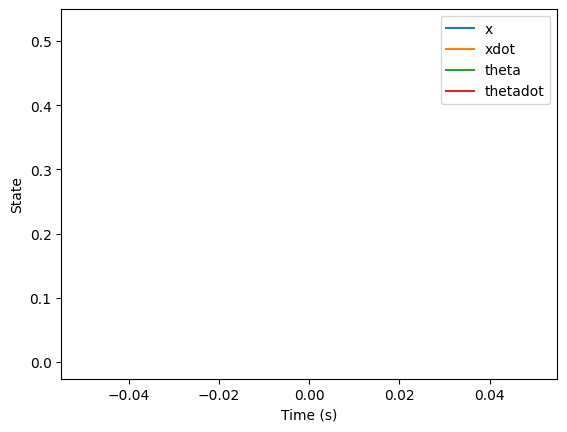

In [31]:
# Define the initial value for theta
theta_0 = np.pi/6

# Define the state vector x and the control input u
x = np.array([[0], [0], [theta_0], [0]])
u = 0

# Define the cost function weights Q and R
Q = np.diag([100, 100, 1, 1])   # higher weight on theta for control input stability
R = np.array([[0.1]])

# Compute the optimal gain matrix K using the ARE
P = solve_continuous_are(A, B, Q, R) # solves the continuous algebraic Riccati equation
K = np.linalg.inv(R + B.T @ P @ B) @ (B.T @ P @ A)

# Simulate the system with the computed gain matrix K
t0, tf = 0, 50    # initial and final simulation time
dt = 0.01     # time step
t = np.arange(t0, tf, dt)
x_history = np.zeros((4, len(t)))
x_history[:, 0] = x[:, 0]
U = []

for i in range(1, len(t)):
    # Compute the control input using the optimal gain matrix K
    u = -F @ x
    U.append(u)

    # Update the state using the system dynamics
    x_dot = A @ x + B @ u
    
    x[0] = x[0] - x_dot[0] * dt
    x[1] = x[1] + x_dot[1] * dt
    x[2] = x[2] + x_dot[2] * dt
    x[3] = x[3] + x_dot[3] * dt

    # Save the state history
    x_history[:, i] = x[:, 0]

# Plot the state history
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, x_history[0, :], label='x')
plt.plot(t, x_history[1, :], label='xdot')
plt.plot(t, x_history[2, :], label='theta')
plt.plot(t, x_history[3, :], label='thetadot')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.show()

In [19]:
# print eig values of A + BF
print("Eigen values of A + BF", np.linalg.eigvals(A + B @ F))

Eigen values of A + BF [ 0.          0.          0.00030832 -0.00030832]


In [20]:
# append 0 to first element of U
U = np.insert(U, 0, 0)
U = np.array(U).reshape(5000, 1)

print(F)

X = x_history

U = U.reshape(5000, )
X = np.array(X).reshape(4, 5000)
x1 = X[0].reshape(5000, )
x2 = X[1].reshape(5000, )
x3 = X[2].reshape(5000, )
x4 = X[3].reshape(5000, )

print(np.shape(U))
print(np.shape(x1))

[[  0.           0.         200.89999905   0.        ]]
(5000,)
(5000,)


In [21]:
import pandas as pd

df = pd.DataFrame({'x': x1, 'xdot': x2, 'theta': x3, 'thetadot': x4, 'u': U}, )
# print df with style
# print(df)
print(min(U))
df

-1.3357338906195859e+135


,x,xdot,theta,thetadot,u
0,0.000000e+00,0.000000e+00,5.235988e-01,0.000000e+00,0.000000e+00
1,0.000000e+00,-5.387831e-02,5.235988e-01,2.103820e-01,-1.051910e+02
2,5.387831e-04,-1.077566e-01,5.257026e-01,4.207640e-01,-1.051910e+02
3,1.616349e-03,-1.618514e-01,5.299102e-01,6.319913e-01,-1.056137e+02
4,3.234864e-03,-2.163792e-01,5.362301e-01,8.449092e-01,-1.064590e+02
...,...,...,...,...,...
4995,1.416024e+132,-8.975849e+132,5.529236e+132,3.504855e+133,-1.044608e+135
4996,1.505782e+132,-9.544807e+132,5.879721e+132,3.727020e+133,-1.110823e+135
4997,1.601230e+132,-1.014983e+133,6.252423e+132,3.963267e+133,-1.181236e+135
4998,1.702729e+132,-1.079320e+133,6.648750e+132,4.214489e+133,-1.256112e+135


In [22]:
syst = InvertedPendulum()

for i in range(len(X[0])):
    rendered = syst.step( [X[0][i], X[1][i], X[2][i] + np.pi/2, X[3][i]], t=i*0.01)
    cv2.imshow( 'im', rendered )

    # Press q to exit

    if cv2.waitKey(5) == ord('q'):
        break

cv2.destroyAllWindows()

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type
>  - Can't parse 'center'. Sequence item with index 0 has a wrong type


In [32]:
cv2.destroyAllWindows()

